In [2]:
%matplotlib inline
import os
import h5py
import numpy as np
#import dataset_processing.data_freiburg_subject_ordering as subjects_ordering
#import dataset_processing.config.system as sys_config
from scipy.ndimage import gaussian_filter


import SimpleITK as sitk
import math
from scipy import interpolate

from matplotlib import pyplot as plt
from skimage.morphology import skeletonize_3d, binary_dilation, dilation, cube

from utils import normalize_image

import matplotlib
from utils_centerline import (load_masked_data, show_center_lines,load_cropped_data_sliced, 
load_cropped_data_straightened, extract_slice_from_sitk_image, load_masked_data_sliced,
create_center_lines, show_center_lines)

In [3]:
control_seg_path = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/segmenter_rw_pw_hard/controls"
control_path = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy"
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
print(os.listdir(control_seg_path)), print(os.listdir(control_path))

['seg_MACDAVD_101_.npy', 'seg_MACDAVD_102_.npy', 'seg_MACDAVD_103_.npy', 'seg_MACDAVD_104_.npy', 'seg_MACDAVD_105_.npy', 'seg_MACDAVD_106_.npy', 'seg_MACDAVD_117_.npy', 'seg_MACDAVD_118_.npy', 'seg_MACDAVD_119_.npy', 'seg_MACDAVD_122_.npy', 'seg_MACDAVD_124_.npy', 'seg_MACDAVD_127_.npy', 'seg_MACDAVD_134_.npy', 'seg_MACDAVD_142_.npy', 'seg_MACDAVD_148_.npy', 'seg_MACDAVD_152_.npy', 'seg_MACDAVD_109_.npy', 'seg_MACDAVD_145_.npy', 'seg_MACDAVD_129_.npy', 'seg_MACDAVD_110_.npy', 'seg_MACDAVD_116_.npy', 'seg_MACDAVD_120_.npy', 'seg_MACDAVD_126_.npy', 'seg_MACDAVD_132_.npy', 'seg_MACDAVD_135_.npy', 'seg_MACDAVD_137_.npy', 'seg_MACDAVD_146_.npy']
['MACDAVD_101_.npy', 'MACDAVD_102_.npy', 'MACDAVD_103_.npy', 'MACDAVD_104_.npy', 'MACDAVD_105_.npy', 'MACDAVD_106_.npy', 'MACDAVD_107_.npy', 'MACDAVD_108_.npy', 'MACDAVD_109_.npy', 'MACDAVD_145_.npy', 'MACDAVD_148_.npy', 'MACDAVD_150_.npy', 'MACDAVD_152_.npy', 'MACDAVD_154_.npy', 'MACDAVD_110_.npy', 'MACDAVD_111_.npy', 'MACDAVD_113_.npy', 'MACDAVD_1

(None, None)

In [4]:
img = np.load(os.path.join(control_path, os.listdir(control_path)[0]))
seg = np.load(os.path.join(control_seg_path, os.listdir(control_seg_path)[0]))

#img = np.load("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/3/10000000/10000001/image.npy")
#seg = np.load("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/3/10000000/10000001/random_walker_prediction.npy")
#model_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full'
#save_path_pred = model_path + "/results/visualization/Bern_patient_level_prediction/"
#file_name = 'freiburg_model_prediction_105.npy'
#seg = np.load(os.path.join(save_path_pred, file_name))
#img = np.load(os.path.join(control_path, os.listdir(control_path)[4]))

In [4]:
img.shape, seg.shape

((160, 110, 56, 23, 4), (160, 110, 56, 23))

In [5]:
try:
    debug_in = img
    debug_label = seg
    #slice_ = 0
    print(slice_)
    %matplotlib inline
    plt.imshow(debug_in[:, :,slice_, 3,0])
    plt.show()
    plt.imshow(debug_in[:, :,slice_, 3,0])
    plt.imshow(debug_label[:, :,slice_, 3], alpha= 0.1)
    slice_ +=1 
    plt.show()
except:
    pass

##### Masked data 
- I am loading both the Bern data and also some from Freiburg with the original script to make sure I am on track

In [5]:
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
#masked_data = h5py.File(basepath + '/size_32_masked_images_from_101_to_104.hdf5','r')
masked_data = load_masked_data(basepath, 40101, 40104, 'train', force_overwrite=False)
images_masked = masked_data['masked_images_train']
labels_masked = masked_data['masked_images_train']

Already preprocessed this configuration. Loading now...


In [6]:


masked_data_fr = h5py.File("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/masked_images_from20to26.hdf5",'r')
images_masked_fr = masked_data_fr['masked_images_validation']

In [7]:
images_masked.shape, labels_masked.shape

((160, 144, 112, 48, 4), (160, 144, 112, 48, 4))

In [8]:
import matplotlib
masked_array = np.ma.masked_where(images_masked[:, :,:, 3,1] == 0, images_masked[:, :,:, 3,1])

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='black')


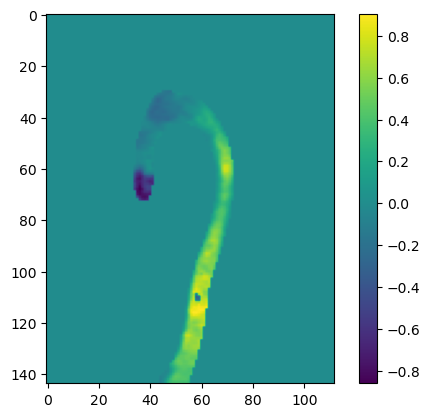

In [9]:
%matplotlib inline
plt.imshow(images_masked[22, :,:, 3,1])
plt.colorbar()
plt.show()

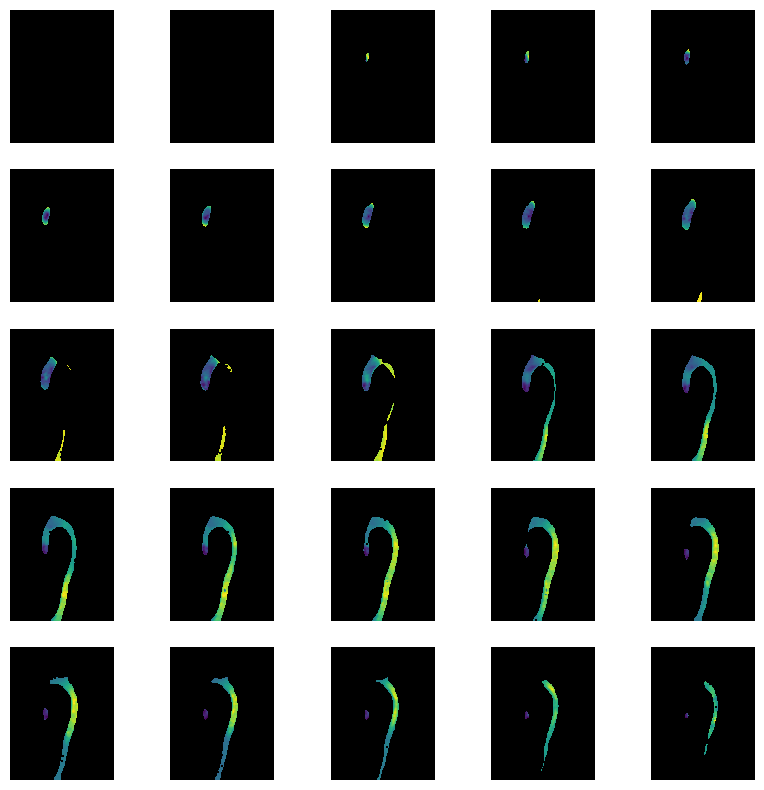

In [12]:

fig, axs = plt.subplots(5,5, figsize=(10,10))
ax = axs.ravel()
for i in range(25):
    ax[i].imshow(masked_array[(i+6), :,:], cmap=cmap)
    #ax[i].set_title(i)
    ax[i].axis('off')

In [13]:
%matplotlib inline
print("Freiburg")
plt.imshow(images_masked_fr[21, :,:, 3,1])
plt.show()

Freiburg


NameError: name 'images_masked_fr' is not defined

##### Cropped data and sliced orthogonally

In [10]:
cropped_sliced_data = load_cropped_data_sliced(basepath, 40101, 40104, 'train', force_overwrite=False)
#cropped_sliced_data = h5py.File(basepath + '/sliced_images_from101_to_104.hdf5','r')
images_cropped_sliced = cropped_sliced_data['sliced_images_train']
     

Already preprocessed this configuration. Loading now...


In [11]:
cropped_sliced_data_fr = h5py.File("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/sliced_images_from20to26.hdf5",'r')
images_cropped_sliced_fr = cropped_sliced_data_fr['sliced_images_validation']

#### Now let's load the masked one and show them side by side

In [12]:
masked_cropped_sliced_data = load_masked_data_sliced(basepath, 40101, 40104, 'train', force_overwrite=False)
masked_images_cropped_sliced = masked_cropped_sliced_data['sliced_images_train']

Already preprocessed this configuration. Loading now...


In [13]:
masked_cropped_sliced_data_fr = h5py.File("/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg/masked_sliced_images_from20to26.hdf5",'r')
masked_images_cropped_sliced_fr = masked_cropped_sliced_data_fr['sliced_images_validation']

In [14]:
masked_images_cropped_sliced.shape, images_cropped_sliced.shape, masked_images_cropped_sliced_fr.shape, images_cropped_sliced_fr.shape

((256, 32, 32, 48, 4),
 (256, 32, 32, 48, 4),
 (448, 32, 32, 48, 4),
 (448, 32, 32, 48, 4))

In [15]:
images_cropped_sliced.shape

(256, 32, 32, 48, 4)

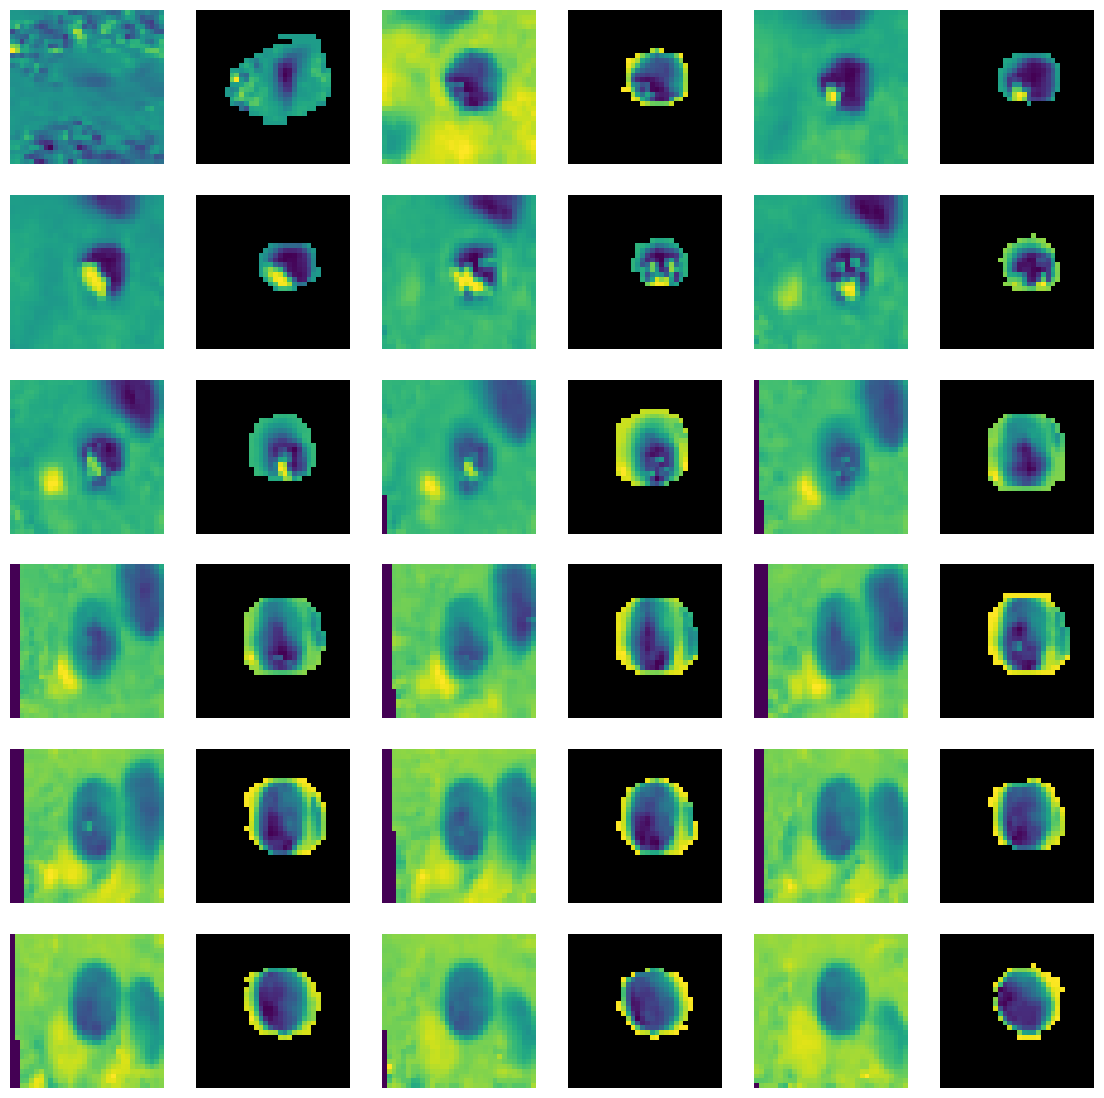

In [16]:
z_slice = 45
z_slices = np.linspace(191,255, 18, dtype=int)
time_slice = 2
channel_slice = 1
fig, axs = plt.subplots(6,6, figsize=(14,14))
ax = axs.ravel()
z_i = 0 
masked_array = np.ma.masked_where(masked_images_cropped_sliced[:, :,:, time_slice,channel_slice] == 0, masked_images_cropped_sliced[:, :,:, time_slice,channel_slice])

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='black')

for i in range(36):
    if i %2 == 0:

        ax[i].imshow(images_cropped_sliced[z_slices[z_i], :,:, time_slice,channel_slice])
    else:
        ax[i].imshow(masked_array[z_slices[z_i], :,:], cmap=cmap)
        z_i +=1
    #ax[i].set_title(i)
    ax[i].axis('off')
#axs[0].imshow(images_cropped_sliced[z_slice, :,:, time_slice,channel_slice])
#axs[1].imshow(masked_images_cropped_sliced[z_slice, :,:, time_slice,channel_slice])
plt.show()

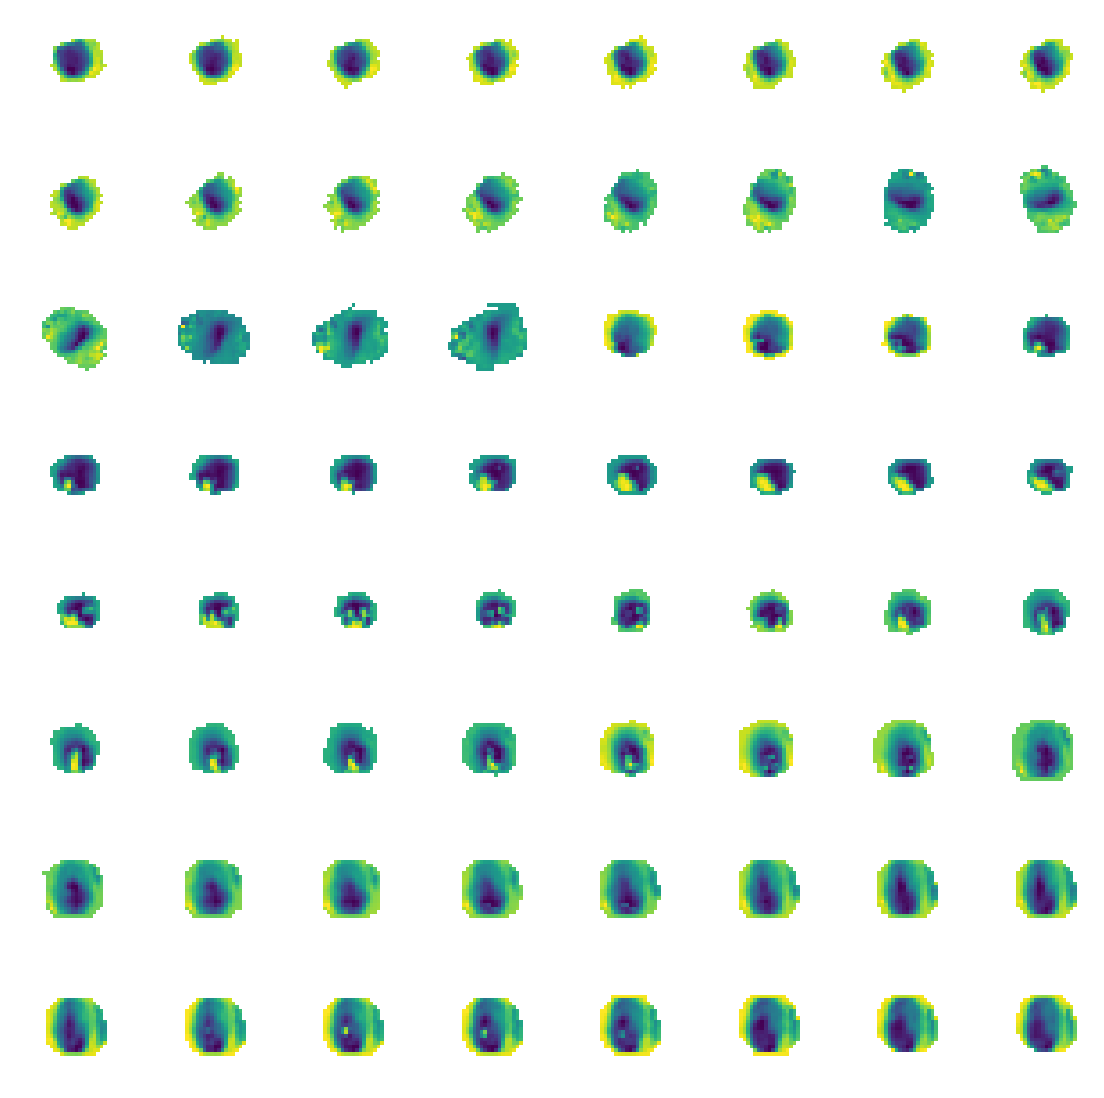

In [20]:
fig, axs = plt.subplots(8,8, figsize=(14,14))
ax = axs.ravel()
for i in range(64):
    ax[i].imshow(masked_array[i+172, :,:])
    #ax[i].set_title(i)
    ax[i].axis('off')

## Testing centerline for pipeline

In [1]:
%matplotlib inline
import os
import pandas as pd
import h5py
import numpy as np
#import dataset_processing.data_freiburg_subject_ordering as subjects_ordering
#import dataset_processing.config.system as sys_config
from scipy.ndimage import gaussian_filter


import SimpleITK as sitk
import math
from scipy import interpolate

from matplotlib import pyplot as plt
from skimage.morphology import skeletonize_3d, binary_dilation, dilation, cube

from utils import normalize_image


from utils_centerline import (load_masked_data, show_center_lines,load_cropped_data_sliced, 
load_cropped_data_straightened, extract_slice_from_sitk_image, load_masked_data_sliced,
create_center_lines, show_center_lines)

from utils_centerline import load_masked_data_patient, load_cropped_data_sliced_patient, load_masked_data_sliced_patient

In [2]:
model_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/inference_results/unet3d_da_0.0nchannels4_r1_loss_crossentropy_cut_z_False_full_run_adaptive_batch_norm_lr_1e-4_e75_tr_27/controls'
hand_seg_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/segmenter_rw_pw_hard/controls'

In [3]:
# actually these are the controls one 
all_seg_paths = [os.path.join(hand_seg_path, f) for f in os.listdir(hand_seg_path)]
all_seg_paths = all_seg_paths + [os.path.join(model_path, f) for f in os.listdir(model_path)]

In [4]:
len(all_seg_paths)

55

In [5]:
# I want to make my life easier so I'll check the shapes and cut where the segmentation is not there

In [6]:
def print_seg_shapes(all_seg_paths):
    x_shapes = []
    y_shapes = []
    z_shapes = []
    t_shapes = []

    for seg_path in all_seg_paths:
        seg = np.load(seg_path)
        x_shapes.append(seg.shape[0])
        y_shapes.append(seg.shape[1])
        z_shapes.append(seg.shape[2])
        t_shapes.append(seg.shape[3])
    df = pd.DataFrame((x_shapes, y_shapes, z_shapes, t_shapes)).T

    df.columns = ["x_shape", "y_shapes", "z_shapes", "t_shapes"]
    return df

In [7]:
def show_center_lines(model_path):
        for i in np.arange(len(os.listdir(model_path))):
    
                # load the segmentation that was created with Nicolas's tool
        
                segmented = np.load(os.path.join(model_path, os.listdir(model_path)[i]))#np.load(basepath + '/' + subjects_ordering.SUBJECT_DIRS[n] + '/random_walker_prediction.npy')
        
                # Average the segmentation over time (the geometry should be the same over time)
                avg = np.average(segmented, axis = 3)
        
                # Compute the centerline points of the skeleton
                skeleton = skeletonize_3d(avg[:,:,:])
        
                # Get the points of the centerline as an array
                points = np.array(np.where(skeleton != 0)).transpose([1,0])
        
                #Load the centerline coordinates for the given subject
                # centerline_coords = centerline_indexes[n]
        
                # print out the points
                for i in range(len(points)):
                        print("Index {}:".format(str(i)) + str(points[i]))
        

        return 0

In [63]:
show_center_lines(model_path)

Index 0:[ 5 57 24]
Index 1:[13 44  7]
Index 2:[13 45 10]
Index 3:[14 44  7]
Index 4:[14 45 10]
Index 5:[15 44  7]
Index 6:[15 46 11]
Index 7:[16 44  7]
Index 8:[16 47 11]
Index 9:[17 47 11]
Index 10:[18 46 12]
Index 11:[18 49 27]
Index 12:[18 50 27]
Index 13:[18 51 28]
Index 14:[18 52 28]
Index 15:[18 53 28]
Index 16:[18 54 29]
Index 17:[18 55 29]
Index 18:[19 46 12]
Index 19:[19 48 26]
Index 20:[19 56 29]
Index 21:[19 57 29]
Index 22:[19 58 29]
Index 23:[19 59 29]
Index 24:[20 46 12]
Index 25:[20 47 26]
Index 26:[20 60 29]
Index 27:[20 61 29]
Index 28:[21 43 15]
Index 29:[21 43 16]
Index 30:[21 43 17]
Index 31:[21 44 14]
Index 32:[21 45 13]
Index 33:[21 46 25]
Index 34:[21 60 38]
Index 35:[21 62 29]
Index 36:[22 43 18]
Index 37:[22 45 24]
Index 38:[22 61 38]
Index 39:[22 63 29]
Index 40:[23 43 19]
Index 41:[23 44 22]
Index 42:[23 45 23]
Index 43:[23 62 38]
Index 44:[23 64 29]
Index 45:[24 43 20]
Index 46:[24 43 21]
Index 47:[24 63 37]
Index 48:[24 64 33]
Index 49:[24 64 34]
Index 50:[

IsADirectoryError: [Errno 21] Is a directory: '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/inference_results/unet3d_da_0.0nchannels4_r1_loss_crossentropy_cut_z_False_full_run_adaptive_batch_norm_lr_1e-4_e75_tr_27/controls/SubjectCenterlines'

In [8]:
from skimage.morphology import skeletonize_3d, dilation, cube
import SimpleITK as sitk
from scipy import interpolate

In [9]:

def tile_3d(X, rows, cols, every_x_time_step):
    """Tile images for display."""
    tiling = np.zeros((rows * X.shape[1], cols * X.shape[2]), dtype = X.dtype)
    for i in range(rows):
        for j in range(cols):
            img = X[i,:,:,j*every_x_time_step]
            tiling[
                    i*X.shape[1]:(i+1)*X.shape[1],
                    j*X.shape[2]:(j+1)*X.shape[2]] = img
    return tiling


def plot_batch_3d(X, channel, every_x_time_step, out_path):

    """
    This method creates a plot of a batch

    param: X - input of dimensions (batches, x, y, t,  channels)
    param: channel - which channel of the images should be plotted (0-3):(intensity,vx,vy,vz)
    param: every_x_time_step - for 1, all timesteps are plotted, for 2, every second timestep is plotted etc..
    param: out_path - path of the folder where the plots should be saved
    """

    X = np.stack(X)
    X = X[:,:,:,:,channel]

    rows = X.shape[0]
    cols = math.ceil(X.shape[3] // every_x_time_step)
    canvas = tile_3d(X, rows, cols, every_x_time_step)
    canvas = np.squeeze(canvas)

    plt.imsave(out_path, canvas, cmap='gray')


In [10]:

def interpolate_and_slice(image,
                          coords,
                          size):


    #coords are a bit confusing in order...
    x = coords[:,0]
    y = coords[:,1]
    z = coords[:,2]

    coords = np.array([z,y,x]).transpose([1,0])

    #convert the image to SITK (here let's use the intensity for now)
    sitk_image = sitk.GetImageFromArray(image[:,:,:])

    # spline parametrization
    params = [i / (size[2] - 1) for i in range(size[2])]
    tck, _ = interpolate.splprep(np.swapaxes(coords, 0, 1), k=3, s=200)

    # derivative is tangent to the curve
    points = np.swapaxes(interpolate.splev(params, tck, der=0), 0, 1)
    Zs = np.swapaxes(interpolate.splev(params, tck, der=1), 0, 1)
    direc = np.array(sitk_image.GetDirection()[3:6])

    slices = []
    for i in range(len(Zs)):
        # I define the x'-vector as the projection of the y-vector onto the plane perpendicular to the spline
        xs = (direc - np.dot(direc, Zs[i]) / (np.power(np.linalg.norm(Zs[i]), 2)) * Zs[i])
        sitk_slice = extract_slice_from_sitk_image(sitk_image, points[i], Zs[i], xs, list(size[:2]) + [1], fill_value=0)
        np_image = sitk.GetArrayFromImage(sitk_slice).transpose(2, 1, 0)
        slices.append(np_image)

    # stick slices together
    return np.concatenate(slices, axis=2)

In [11]:
def create_center_lines(model_path):

    # ==========================================
    # ==========================================
    #num_images_to_load = idx_end + 1 - idx_start
    centerline_indexes = [
        [7, 43, 81, 115, 130, 148, 200, 220, 250],
        [10, 43, 81, 115, 130, 148, 200, 220, 270],
        [7, 43, 60, 75, 80, 100, 120, 150, 180],
        [7, 43, 81, 85, 95, 110, 160, 200, 212],
        [7, 43, 81, 115, 130, 148, 152, 170, 190],
        [5, 33, 72, 83, 88, 100, 112, 140, 160],
        [7, 43, 72, 115, 130, 148, 152, 190, 210],
        [7, 34, 64, 81, 90, 102, 110, 141, 150],
        [10, 33, 50, 74, 85, 95, 100, 120, 149],
        [7, 22,43, 81, 115,120, 130, 148, 152],
        [7,22, 43, 81,100, 115, 130, 148, 152],
        [7, 43, 81, 92,115, 130, 148, 152, 170],
        [7, 21,43, 81, 115, 130, 148, 152, 160],
        [7, 43, 81, 115, 130, 148, 152, 170, 190],
        [7, 43, 81, 115, 130, 148, 152, 170, 220],
        [7, 43, 81, 131, 151, 180, 220, 240, 260],
        [7, 43, 62, 80, 85, 90, 100, 110, 145],
        [7, 100, 400, 500, 600, 700, 800, 900, 1000],
        [7, 22,43, 81, 115, 130, 148, 152, 170],
        [7, 43, 81, 115, 130, 148, 152, 170, 220],
        [7, 43, 81, 115, 130, 148, 152, 170, 190],
        [7, 43, 81, 115, 130, 148, 152, 170, 190],
        [7, 43, 81, 115, 130, 148, 152, 170, 190],
        [7, 43, 81, 92,115, 130, 148, 152, 170],
        [7, 43, 81, 85, 95, 110, 160, 200, 212],
        [7, 43, 81, 115, 130, 148, 152, 170, 190],


    ]
    """
    # For now Bern has 6 segmentations (no idea how to choose them)
    centerline_indexes = [
        [7, 43, 55, 81, 115, 130, 148],
        [11, 44, 87, 119, 131, 160, 190],
        [9, 30,  72, 89, 119, 150, 175],
        [2,  34, 55, 81, 120, 151, 170],
        [15, 34, 35, 74, 110, 150, 190],
        [5, 14, 34, 73, 90, 130, 180],
        ]
    """
    """
    centerline_indexes = [
        [115, 81, 43, 7, 52, 120, 160],
        [87, 44, 11, 19, 89, 119, 131],
        [72, 30, 7, 49, 89, 119, 150],
        [94, 31, 0, 34, 81, 120, 151],
        [74, 34, 15, 35, 79, 110],
        [73, 14, 5, 34, 74, 119],
    ]
    """
    seg_path = model_path
    img_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy'
    basepath = model_path

    i = 0
    for n, patient in enumerate(os.listdir(seg_path)):
        name = patient.replace("seg_", "").replace("_.npy", "")

        print("========================================================================")
        print('Loading subject ' + str(n+1) + ' out of ' + str(len(os.listdir(seg_path))) + '...')
        print('Patient\'s name: ' + name)
        print("========================================================================")

        # load the segmentation that was created with Nicolas's tool
        image = np.load(img_path + f'/{patient.replace("seg_", "")}')#np.load(basepath + '/' + subjects_ordering.SUBJECT_DIRS[n] + '/image.npy')
        segmented = np.load(seg_path + f'/{patient}')#np.load(basepath + '/' + subjects_ordering.SUBJECT_DIRS[n] + '/random_walker_prediction.npy')
        # Average the segmentation over time (the geometry should be the same over time)
        avg = np.average(segmented, axis = 3)

        # Compute the centerline points of the skeleton
        skeleton = skeletonize_3d(avg[:,:,:])

        # Get the points of the centerline as an array
        points = np.array(np.where(skeleton != 0)).transpose([1,0])

        #Load the centerline coordinates for the given subject
        centerline_coords = centerline_indexes[n]
        
        

        # print out the points
        """
        for i in range(len(points)):
            print("Index {}:".format(str(i)) + str(points[i]))


        #===========================================================================================
        # Parameters for the interpolation and creation of the files
        size = (30,30,256)
        coords = np.array(points[centerline_coords])

        # Create Slices across time and channels in a double for loop
        temp_for_channel_stacking = []
        for channel in range(image.shape[4]):

            temp_for_time_stacking = []
            for t in range(image.shape[3]):
                straightened = interpolate_and_slice(image[:,:,:,t,channel], coords, size)
                temp_for_time_stacking.append(straightened)

            channel_stacked = np.stack(temp_for_time_stacking, axis=-1)
            temp_for_channel_stacking.append(channel_stacked)

        straightened = np.stack(temp_for_channel_stacking, axis=-1)

        img_list = []
        img_list.append(straightened)
        """
        # ================================
        # VISUALIZATIONS
        # ================================
        #exp_path = os.path.join('/',*model_path.split('/')[:-1])
        exp_path = basepath
        if not os.path.exists(exp_path + '/SubjectCenterlines/'):
            os.makedirs(exp_path + '/SubjectCenterlines/')

        fig = plt.figure('Centerline')
        plt.imshow(image[:,:,15,3,0], cmap='gray')
        plt.scatter(points[:,1],points[:,0], s=2, c='red', marker='o')
        name = exp_path + '/SubjectCenterlines/' + f'{name}' +'.png'
        fig.savefig(name)
        plt.close()
        


        """

        num_slices = size[2]
        image_out  = img_list[0]
        # ================================
        # all slices of each time-index as png
        # ================================
        # %config InlineBackend.figure_format = "retina"
        figure2 = plt.figure(figsize=[120,120])
        for j in range(num_slices-1):
            plt.subplot(16, 16 , j+1)
            plt.imshow(image_out[:,:,j,3,0], cmap='gray')

        
        

        name = exp_path + '/SubjectCenterlines/' + 'Straightened_' + str(n) +'.png'
        figure2.savefig(name)
        plt.close()

        figure2 = plt.figure(figsize=[120,120])
        for j in range(size[0]):
            plt.subplot(6, 6 , j+1)
            plt.imshow(image_out[:,j,:,3,0], cmap='gray')

        name = exp_path + '/SubjectCenterlines/' + 'Straightened_SideView_' + str(n) +'.png'
        figure2.savefig(name)
        plt.close()

        #test plot batch function
        #(x,y,z,t,channel)
        for channel in range(4):
            name = exp_path + '/SubjectCenterlines/' + 'Straightened_SideView_' + str(n) + 'channel_' + str(channel) +'.png'
            plot_batch_3d(image_out,channel,2,name)

        print("========================================================================\n\n")
        """
    return 0


In [12]:
create_center_lines(hand_seg_path)

Loading subject 1 out of 27...
Patient's name: MACDAVD_101
Loading subject 2 out of 28...
Patient's name: MACDAVD_102
Loading subject 3 out of 28...
Patient's name: MACDAVD_103
Loading subject 4 out of 28...
Patient's name: MACDAVD_104
Loading subject 5 out of 28...
Patient's name: MACDAVD_105
Loading subject 6 out of 28...
Patient's name: MACDAVD_106
Loading subject 7 out of 28...
Patient's name: MACDAVD_117
Loading subject 8 out of 28...
Patient's name: MACDAVD_118
Loading subject 9 out of 28...
Patient's name: MACDAVD_119
Loading subject 10 out of 28...
Patient's name: MACDAVD_122
Loading subject 11 out of 28...
Patient's name: MACDAVD_124
Loading subject 12 out of 28...
Patient's name: MACDAVD_127
Loading subject 13 out of 28...
Patient's name: MACDAVD_134
Loading subject 14 out of 28...
Patient's name: MACDAVD_142
Loading subject 15 out of 28...
Patient's name: MACDAVD_148
Loading subject 16 out of 28...
Patient's name: MACDAVD_152
Loading subject 17 out of 28...
Patient's name: M

IndexError: list index out of range

In [11]:
create_center_lines(model_path=model_path)

Loading subject 1 out of 28...
Patient's name: MACDAVD_107
Loading subject 2 out of 28...
Patient's name: MACDAVD_108
Loading subject 3 out of 28...
Patient's name: MACDAVD_150
Loading subject 4 out of 28...
Patient's name: MACDAVD_154
Loading subject 5 out of 28...
Patient's name: MACDAVD_111
Loading subject 6 out of 28...
Patient's name: MACDAVD_113
Loading subject 7 out of 28...
Patient's name: MACDAVD_114
Loading subject 8 out of 28...
Patient's name: MACDAVD_115
Loading subject 9 out of 28...
Patient's name: MACDAVD_121
Loading subject 10 out of 28...
Patient's name: MACDAVD_123
Loading subject 11 out of 28...
Patient's name: MACDAVD_125
Loading subject 12 out of 28...
Patient's name: MACDAVD_128
Loading subject 13 out of 28...
Patient's name: MACDAVD_130
Loading subject 14 out of 28...
Patient's name: MACDAVD_131
Loading subject 15 out of 28...
Patient's name: MACDAVD_133
Loading subject 16 out of 28...
Patient's name: MACDAVD_136
Loading subject 17 out of 28...
Patient's name: M

IndexError: list index out of range

In [40]:

masked_data = load_masked_data_patient(model_path,0,2, 'train', force_overwrite=False)
images_masked = masked_data['masked_images_train']
labels_masked = masked_data['masked_images_train']

Already preprocessed this configuration. Loading now...


In [9]:
images_masked.shape, labels_masked.shape

((80, 144, 112, 48, 4), (80, 144, 112, 48, 4))

In [10]:
import matplotlib
masked_array = np.ma.masked_where(images_masked[:, :,:, 3,1] == 0, images_masked[:, :,:, 3,1])

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='black')



##### Cropped data and sliced orthogonally

In [11]:
model_path

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/inference_results/unet3d_da_0.0nchannels4_r1_loss_crossentropy_cut_z_False_full_run_adaptive_batch_norm_lr_1e-4_e75_tr_27/controls'

In [12]:
cropped_sliced_data = load_cropped_data_sliced_patient(model_path, 0, 2, 'train')
#cropped_sliced_data = h5py.File(basepath + '/sliced_images_from101_to_104.hdf5','r')
images_cropped_sliced = cropped_sliced_data['sliced_images_train']
     

Already preprocessed this configuration. Loading now...


In [13]:
images_cropped_sliced.shape

(128, 32, 32, 48, 4)

In [14]:
plt.imshow(images_cropped_sliced[110,:,:,22,0])

#### Now let's load the masked one and show them side by side

In [15]:
masked_cropped_sliced_data = load_masked_data_sliced_patient(model_path, 0, 2, 'train')
masked_images_cropped_sliced = masked_cropped_sliced_data['sliced_images_train']

This configuration has not yet been preprocessed.
Preprocessing now...
loading subject 0 out of 2...
[[  5  57  24]
 [ 13  44   7]
 [ 13  45  10]
 [ 14  44   7]
 [ 14  45  10]
 [ 15  44   7]
 [ 15  46  11]
 [ 16  44   7]
 [ 16  47  11]
 [ 17  47  11]
 [ 18  46  12]
 [ 18  49  27]
 [ 18  50  27]
 [ 18  51  28]
 [ 18  52  28]
 [ 18  53  28]
 [ 18  54  29]
 [ 18  55  29]
 [ 19  46  12]
 [ 19  48  26]
 [ 19  56  29]
 [ 19  57  29]
 [ 19  58  29]
 [ 19  59  29]
 [ 20  46  12]
 [ 20  47  26]
 [ 20  60  29]
 [ 20  61  29]
 [ 21  43  15]
 [ 21  43  16]
 [ 21  43  17]
 [ 21  44  14]
 [ 21  45  13]
 [ 21  46  25]
 [ 21  60  38]
 [ 21  62  29]
 [ 22  43  18]
 [ 22  45  24]
 [ 22  61  38]
 [ 22  63  29]
 [ 23  43  19]
 [ 23  44  22]
 [ 23  45  23]
 [ 23  62  38]
 [ 23  64  29]
 [ 24  43  20]
 [ 24  43  21]
 [ 24  63  37]
 [ 24  64  33]
 [ 24  64  34]
 [ 24  65  29]
 [ 24  65  32]
 [ 25  43  20]
 [ 25  64  35]
 [ 25  64  36]
 [ 25  64  37]
 [ 25  66  29]
 [ 25  66  31]
 [ 26  42  19]
 [ 26  65  38]

In [16]:
masked_images_cropped_sliced.shape, images_cropped_sliced.shape

((128, 32, 32, 48, 4), (128, 32, 32, 48, 4))

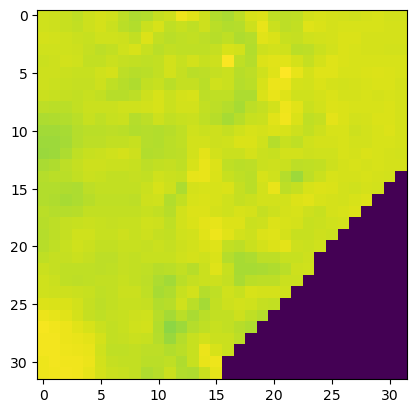

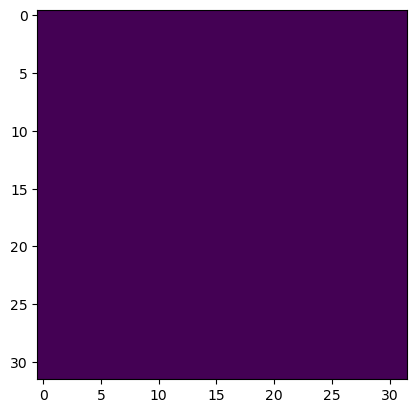

In [19]:
%matplotlib inline
plt.imshow(images_cropped_sliced[94, :,:, 22,1])
plt.show()
plt.imshow(masked_images_cropped_sliced[94, :,:, 22,1])

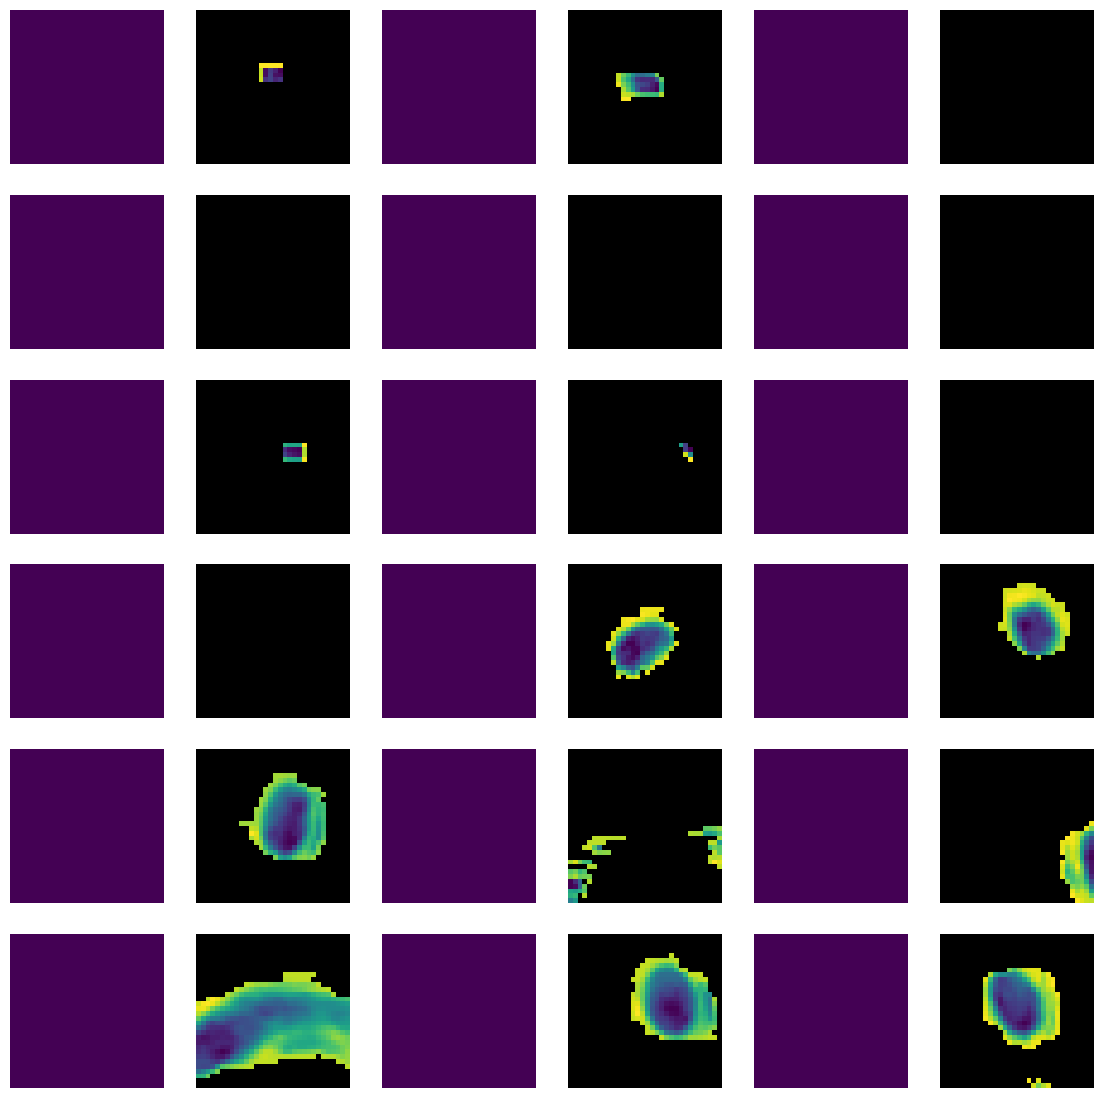

In [26]:
z_slice = 20
z_slices = np.linspace(64, 127, 18, dtype=int)
time_slice = 2
channel_slice = 1
fig, axs = plt.subplots(6,6, figsize=(14,14))
ax = axs.ravel()
z_i = 0 
masked_array = np.ma.masked_where(masked_images_cropped_sliced[:, :,:, time_slice,channel_slice] == 0, masked_images_cropped_sliced[:, :,:, time_slice,channel_slice])

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='black')

for i in range(36):
    if i %2 == 0:

        ax[i].imshow(images_cropped_sliced[z_slices[z_i], :,:, time_slice,channel_slice])
    else:
        ax[i].imshow(masked_array[z_slices[z_i], :,:], cmap=cmap)
        z_i +=1
    #ax[i].set_title(i)
    ax[i].axis('off')
#axs[0].imshow(images_cropped_sliced[z_slice, :,:, time_slice,channel_slice])
#axs[1].imshow(masked_images_cropped_sliced[z_slice, :,:, time_slice,channel_slice])
plt.show()

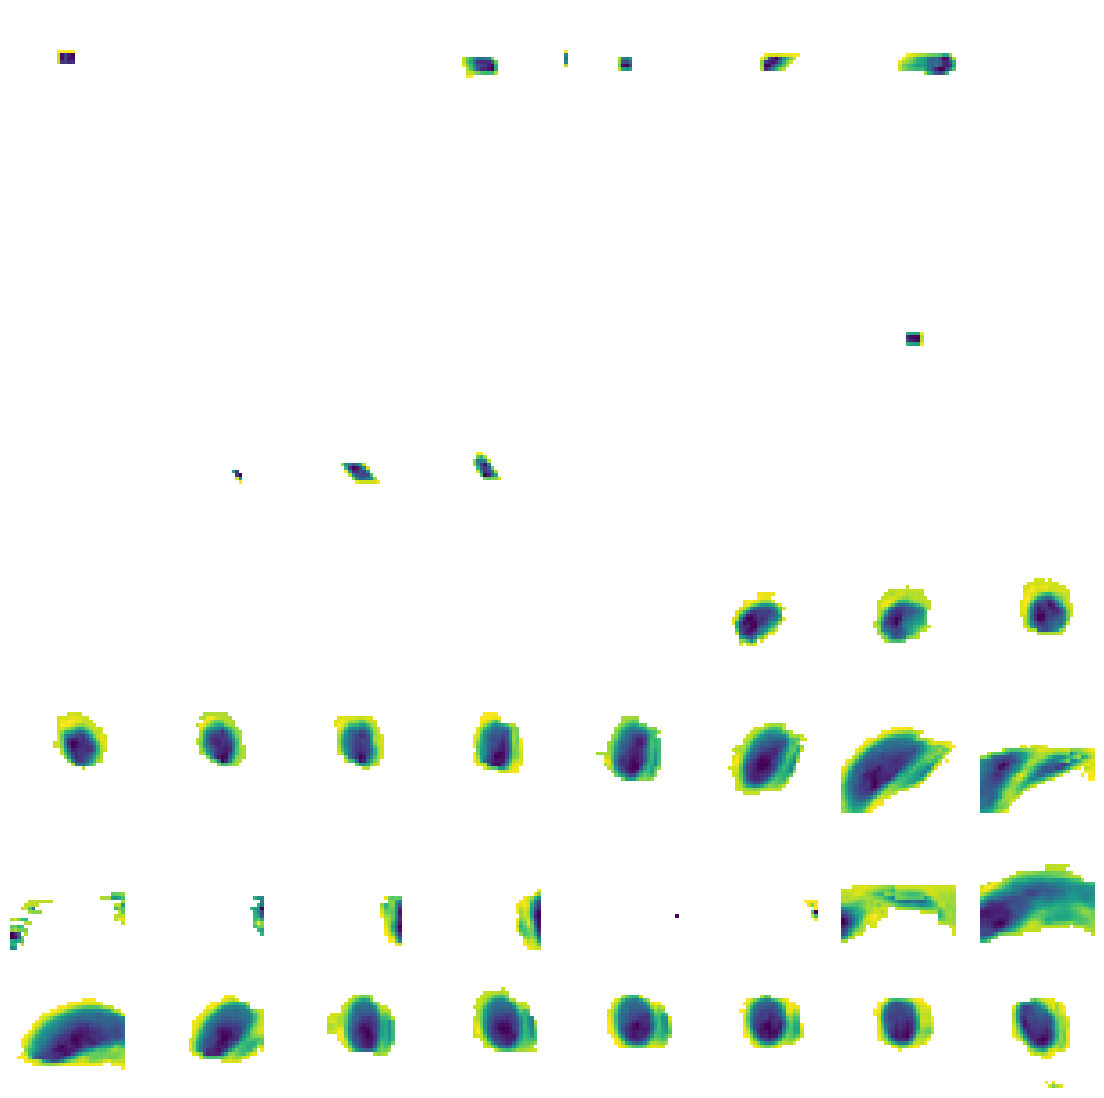

In [38]:
fig, axs = plt.subplots(8,8, figsize=(14,14))
ax = axs.ravel()
for i in range(64):
    ax[i].imshow(masked_array[i+64, :,:])
    #ax[i].set_title(i)
    ax[i].axis('off')

In [ ]:
fig, axs = plt.subplots(8,8, figsize=(14,14))
ax = axs.ravel()
for i in range(64):
    ax[i].imshow(masked_array[i+64, :,:])
    #ax[i].set_title(i)
    ax[i].axis('off')